# Optimal execution with power law temporary price impact and price limit 

In [1]:
name = 'tf_price_limit_clean'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')    
from numba import vectorize
import os
import time


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
tf.reset_default_graph()
os.environ["CUDA_VISIBLE_DEVICES"] = ""
K.clear_session()
num_paths=10

Using TensorFlow backend.


In [2]:
N = 100 # time steps
T = 1. # time horizon
sigma = 0.2 # volatility
alpha = 0.6 # temporary price impact
dt = T/N
num_samples = 10000
num_shares = 1.
b = 0.3 # permanent market impact


batch_size = 64
price_limit = 0.2 # 
phi = 0
beta = 20
version = 1
n_batches = num_samples // batch_size


In [3]:
params = {"hidden1": 100, "hidden2": 100,  
              "hidden3": 66, 
              "droput1":0.45,  "droput2": 0.3,
              "optimizer": 'rmsprop', "epochs": 8}

In [4]:
%%time
data = np.random.normal(0, 1, (num_samples, N))*np.sqrt(dt)
timesteps = np.linspace(0, T-dt, N)

CPU times: user 46.2 ms, sys: 0 ns, total: 46.2 ms
Wall time: 45.7 ms


In [5]:
timeline = np.zeros_like(data)
timeline[:] = timesteps
timeline.shape

(10000, 100)

In [6]:
X_data = np.zeros((data.shape[0],3))
X_data[:] = [0., 0., num_shares]

## Building the computational graph

In [7]:

def tf_power(alpha):
    def f(x):
        return tf.pow(x, alpha)
    return f

In [8]:
X = tf.placeholder(shape=[None, 3], dtype=tf.float32)
noise = tf.placeholder(shape=[None, N], dtype=tf.float32)
# time, current_price, shares remaining to buy

def speed(X):
    hidden1 = tf.layers.dense(inputs = X, units=params["hidden1"], activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=hidden1, rate=0.2)
    hidden2 = tf.layers.dense(inputs = dropout1, units=params["hidden2"], activation=tf.nn.relu)
    logit = tf.layers.dense(inputs = hidden2, units=1, activation=None)
    trading_speed = tf.nn.softplus(logit)
    return trading_speed
    

In [9]:
#logit = tf.layers.dense(inputs = hidden2, units=1, activation=None)

trading_speed = speed(X)

In [10]:
temporary_impact_function = tf_power(alpha)
# vector of temporary price impacts

price_impact = temporary_impact_function(trading_speed)

In [12]:
### tensors of [None, ] shape
current_time = tf.zeros_like(X[:,0:1])
current_price  = tf.zeros_like(X[:,0:1])
shares_remaining_to_buy = num_shares * tf.ones_like(X[:,0:1])

current_input = tf.concat([current_time, current_price, shares_remaining_to_buy], axis=1)


running_cost_of_purchase = tf.zeros_like(X[:,0:1])
running_terminal_buy_cost = tf.zeros_like(X[:,0:1])
running_inventory_penalty = tf.zeros_like(X[:,0:1])


price_limit_tensor = price_limit * tf.ones_like(X[:,0:1])

path_running_cost_of_purchase = running_cost_of_purchase
path_running_terminal_buy_cost = running_terminal_buy_cost
path_running_inventory_penalty = running_inventory_penalty
path_current_price = current_price
path_current_speed = tf.zeros_like(X[:,0:1])
path_shares_remaining_to_buy = shares_remaining_to_buy

In [13]:
path_current_speed 

<tf.Tensor 'zeros_like_6:0' shape=(?, 1) dtype=float32>

In [14]:
for j in range(N):
    current_speed = speed(current_input)
    path_current_speed = tf.concat([path_current_speed, current_speed], axis=1)
    current_price_impact = temporary_impact_function(current_speed)
    if (j<N):
        price_move = np.sqrt(sigma) * noise[:, j:j+1]
        current_time = dt * j * tf.ones_like(current_speed)#tf.timeline[:batch_size, j+1:j+2]
        current_price = tf.add(current_price, price_move)
        current_price_of_execution = current_price + current_price_impact
        current_inventory_penalty = dt * phi * tf.square(shares_remaining_to_buy)
        terminal_buy_cost = tf.multiply(shares_remaining_to_buy, tf.add(current_price, 
                                                                        beta * shares_remaining_to_buy))
    
        # we update the number of shares remaing to be bought
        shares_remaining_to_buy = tf.subtract(shares_remaining_to_buy, dt * current_speed)
        path_shares_remaining_to_buy = tf.concat([path_shares_remaining_to_buy, 
                                                 shares_remaining_to_buy], axis=1)
        #we update the current_input
    
        current_input = tf.concat([current_time, current_price, shares_remaining_to_buy], axis=1)
        
    path_current_price = tf.concat([path_current_price, current_price], axis=1)
    
    running_cost_of_purchase = tf.add(running_cost_of_purchase,
                                      dt * tf.multiply(current_price_of_execution, current_speed))
    path_running_cost_of_purchase = tf.concat([path_running_cost_of_purchase, 
                                               running_cost_of_purchase], axis=1)
                                      
                                      
    running_inventory_penalty = tf.add(running_inventory_penalty, current_inventory_penalty)
    path_running_inventory_penalty = tf.concat([path_running_inventory_penalty, 
                                                running_inventory_penalty], axis=1)
    
    running_terminal_buy_cost = tf.multiply(shares_remaining_to_buy, tf.add(current_price, beta * shares_remaining_to_buy))
    path_running_terminal_buy_cost = tf.concat([path_running_terminal_buy_cost, 
                                        running_terminal_buy_cost], axis=1)
    
    
    
    #current_price = tf.add(current_price, price_move)
    #path_current_price = tf.concat([path_current_price, tf.expand_dims(current_price, axis=1)], axis=1)
    
    #current_price_of_execution = tf.add(current_price, price_impact[:, j])
    #running_cost_of_purchase = tf.add(running_cost_of_purchase, 
                                      #dt * tf.multiply(current_price_of_execution, trading_speed[:,j]))
    #path_running_cost_of_purchase = tf.concat([path_running_cost_of_purchase, 
                                              #tf.expand_dims(running_cost_of_purchase, axis=1)], axis=1)
    # v_t_j * S^v_(t_(j+1))
    
    #terminal_buy_cost = tf.multiply(shares_remaining_to_buy, tf.add(current_price, beta * shares_remaining_to_buy))
    #path_terminal_buy_cost = tf.concat([path_terminal_buy_cost, 
                                        #tf.expand_dims(terminal_buy_cost, axis=1)], axis=1)
    
    #shares_remaining_to_buy = tf.subtract(shares_remaining_to_buy, dt * trading_speed[:, j])
    #path_shares_remaining_to_buy = tf.concat([path_shares_remaining_to_buy,
                                             #tf.expand_dims(shares_remaining_to_buy, axis=1)], axis=1)

In [15]:
path_running_cost_of_purchase = path_running_cost_of_purchase[:, 1:]
path_running_inventory_penalty = path_running_inventory_penalty[:, 1:]
path_running_terminal_buy_cost = path_running_terminal_buy_cost[:, 1:]
path_current_speed = path_current_speed[:,1:]
path_current_price = path_current_price[:, 1:]
path_shares_remaining_to_buy = path_shares_remaining_to_buy[:,1:]

In [16]:
path_shares_remaining_to_buy

<tf.Tensor 'strided_slice_114:0' shape=(?, 100) dtype=float32>

## Determine the stopping time

In [17]:
path_price_limit = price_limit * tf.ones_like(path_current_price)

w = - path_current_price + path_price_limit 


def stopping_util(w):
    return tf.where(w>tf.zeros_like(w), tf.ones_like(w, dtype=tf.int32), tf.zeros_like(w,  dtype=tf.int32))

mask = stopping_util(w)
temp2 = tf.argmin(mask, axis=1)
temp1 = (N-1) * tf.ones_like(temp2, dtype=tf.int64)
stopping_time = tf.where(temp2 > tf.zeros_like(temp2), temp2, temp1)
stopping_time_ex = tf.expand_dims(stopping_time, axis=1)

In [18]:
def terminal(tensor, batch = batch_size):
    temp = tf.constant([0.])
    for j in range(batch):
        temp = tf.concat([temp, tensor[j:j+1,stopping_time_ex[j,0]]], axis=0)
    #res = tensor[:, stopping_time_ex[:, 0]]
    return temp[1:]

## Define the loss and choose optimizer

In [19]:
loss1 = terminal(path_running_cost_of_purchase)
loss2 = terminal(path_running_terminal_buy_cost)
loss3 = terminal(path_running_inventory_penalty)

loss1_batch = tf.reduce_mean(terminal(path_running_cost_of_purchase), axis=0)
loss2_batch = tf.reduce_mean(terminal(path_running_terminal_buy_cost), axis=0)
loss3_batch = tf.reduce_mean(terminal(path_running_inventory_penalty), axis=0)

loss = loss1_batch + loss2_batch + loss3_batch

loss_vector = loss1 + loss2 + loss3



optimize = tf.train.RMSPropOptimizer(0.001).minimize(loss)

init = tf.global_variables_initializer()

## Train the model

In [20]:

with tf.device('/cpu:0'):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, \
                  log_device_placement=True)) as sess:
        #sess.run(tf.global_variables_initializer())
   # with tf.Session() as sess:
        # Run your code
        saver = tf.train.Saver()    
        start_global_time = time.time()
        sess.run(init)
        writer = tf.summary.FileWriter('graphs/', sess.graph)
        for epoch in range(params["epochs"]):
            for step in range(n_batches):
                X_batch = X_data[step * batch_size: step * batch_size + batch_size]
                noise_batch = data[step * batch_size: step * batch_size + batch_size]
                _, train_loss = sess.run([optimize, loss], feed_dict={noise: noise_batch, X: X_batch})
            if (epoch + 1) % 2 == 0:
                time_now = time.time()
                time_per_epoch = (time_now-start_global_time)/(epoch+1)
                train_loss = sess.run([loss], feed_dict={noise: noise_batch, X: X_batch})
                                                                     
                print('Epoch nr: ', epoch+1, ' Current loss: ', train_loss)
                print('Expected time remaining: %.2f seconds.' % (time_per_epoch * (params["epochs"] - epoch)))
                
        saver.save(sess, "./version_" + str(name))
            
        print("Training finished!")

        writer.close()

Epoch nr:  2  Current loss:  [3.1354246]
Expected time remaining: 125.74 seconds.
Epoch nr:  4  Current loss:  [2.900311]
Expected time remaining: 65.03 seconds.
Epoch nr:  6  Current loss:  [2.849284]
Expected time remaining: 33.09 seconds.
Epoch nr:  8  Current loss:  [2.823064]
Expected time remaining: 9.93 seconds.
Training finished!


In [26]:
def print_paths(num_paths=10):
    with tf.device('/cpu:0'):
        with tf.Session() as sess:
            np.random.shuffle(data)
            feed_dict = {noise: data[:max(num_paths, batch_size)], X: X_data[:max(num_paths, batch_size)]}
            saver.restore(sess, "./version_" + str(name))
           
            price_path = sess.run(path_current_price, feed_dict=feed_dict)
            speed_path = sess.run(path_current_speed, feed_dict=feed_dict)
            stopping_point = sess.run(stopping_time, feed_dict=feed_dict)
            total_cost = sess.run(loss_vector, feed_dict=feed_dict)
            remaining_to_buy = sess.run(path_shares_remaining_to_buy, feed_dict=feed_dict)
            speed_relative_to_shares_to_be_bought = speed_path/remaining_to_buy
            
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-dark')       
    for j in range(num_paths):
        print('Stopping_time: ', stopping_point[j])
        print('Total cost of execution:', total_cost[j])
        plt.plot(timesteps, 0.1*speed_path[j], color='skyblue', label='rescaled_trading_speed')
        plt.plot(timesteps, price_path[j], color='red', label='price_path')
        plt.plot(timesteps, np.ones_like(timesteps) * price_limit, color='orange', label='price_limit')
        plt.axvline(x=stopping_point[j]/float(N), label='stopping_time')
        #plt.plot(timesteps, 0.1*speed_relative_to_shares_to_be_bought[j], color='green', label='relaive_speed')
        plt.legend()
        plt.show()

INFO:tensorflow:Restoring parameters from ./version_tf_price_limit_clean
Stopping_time:  99
Total cost of execution: 1.863987


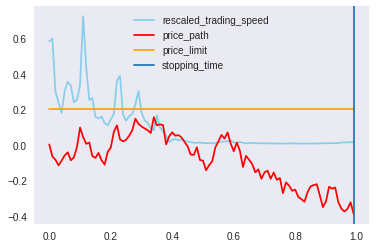

Stopping_time:  57
Total cost of execution: 1.662989


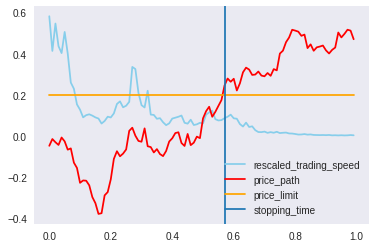

Stopping_time:  99
Total cost of execution: 1.1572819


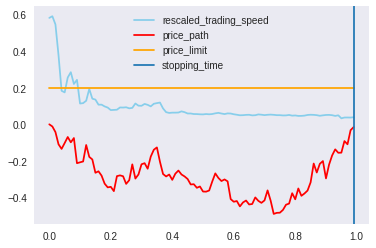

Stopping_time:  12
Total cost of execution: 3.4423287


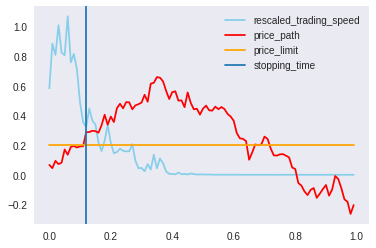

Stopping_time:  99
Total cost of execution: 1.4459165


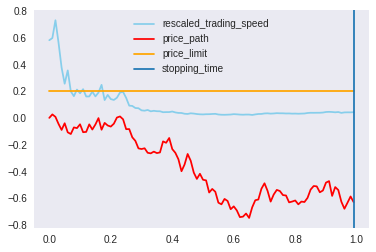

Stopping_time:  38
Total cost of execution: 2.1738188


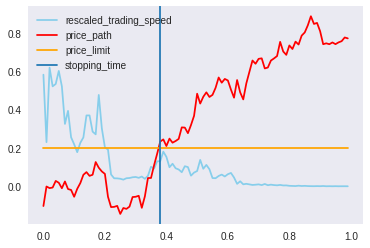

Stopping_time:  99
Total cost of execution: 2.4535024


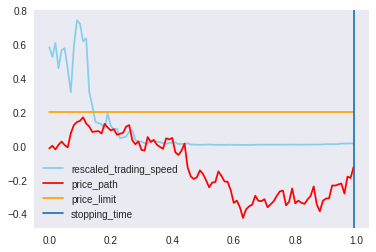

Stopping_time:  49
Total cost of execution: 1.8567866


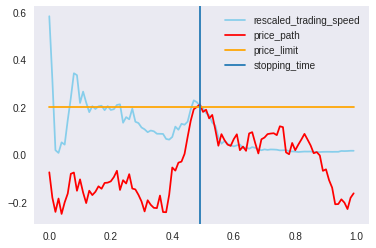

Stopping_time:  99
Total cost of execution: 1.3334157


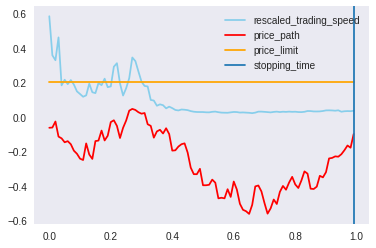

Stopping_time:  5
Total cost of execution: 5.161171


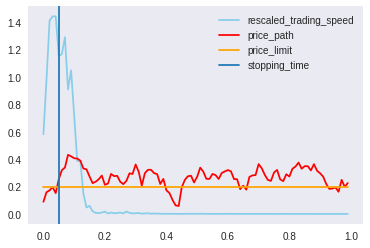

In [27]:
print_paths()

In [23]:

def solution(time, price, shares_remaining):
    with tf.device('/cpu:0'):
        
        with tf.Session() as sess:
            feed_dict = {X: np.array([[time, price, shares_remaining]], dtype=np.float32)}
            saver.restore(sess, "./version_" + str(name))
            result = sess.run(trading_speed, feed_dict=feed_dict)
            
            #X_input = np.array([[time, price, shares_remaining]], dtype=np.float32)
            #feed_dict = {X: X_input}
        
            #result = sess.run(speed(X), feed_dict=feed_dict)
    return result[0,0]

In [24]:
def solution_time(price, shares_remaining):
    with tf.device('/cpu:0'):
        timesteps_n = np.expand_dims(timesteps, axis=0)
        with tf.Session() as sess:
            X_data = np.concatenate([timesteps_n, 
                                     price * np.ones_like(timesteps_n), 
                                     shares_remaining * np.ones_like(timesteps_n)], axis=0)
            X_data = X_data.T
            feed_dict = {X: X_data}
            saver.restore(sess, "./version_" + str(name))
            result = sess.run(trading_speed, feed_dict=feed_dict)
            
            #X_input = np.array([[time, price, shares_remaining]], dtype=np.float32)
            #feed_dict = {X: X_input}
        
            #result = sess.run(speed(X), feed_dict=feed_dict)
    return result

In [25]:
solution(timesteps, 0, 1)

ValueError: setting an array element with a sequence.